In [84]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy

import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
from seaborn import plotting_context

In [85]:
# notes:
# https://matplotlib.org/stable/users/explain/customizing.html

In [86]:
con = duckdb.connect()

con.execute("""
CREATE MACRO pretty_system(s) AS
CASE s
WHEN 'databend' THEN 'Databend'
WHEN 'duckdb' THEN 'DuckDB'
WHEN 'clickhouse' THEN 'ClickHouse'
WHEN 'hyper' THEN 'HyPer'
WHEN 'umbra' THEN 'Umbra'
ELSE s END
""")

def incr():
    global n
    n = n + 1
    return n - 1

n = 1
# WHEN 'l_suppkey' THEN {incr()}
# WHEN 'l_suppkey-l_returnflag-l_linestatus' THEN {incr()}
# WHEN 'l_shipmode' THEN {incr()}
q = f"""
CREATE MACRO grouping_num(grouping) AS
CASE grouping
WHEN 'l_returnflag-l_linestatus' THEN {incr()}
WHEN 'l_partkey' THEN {incr()}
WHEN 'l_partkey-l_returnflag-l_linestatus' THEN {incr()}
WHEN 'l_suppkey-l_partkey' THEN {incr()}
WHEN 'l_orderkey' THEN {incr()}
WHEN 'l_orderkey-l_returnflag-l_linestatus' THEN {incr()}
WHEN 'l_suppkey-l_partkey-l_returnflag-l_linestatus' THEN {incr()}
WHEN 'l_suppkey-l_partkey-l_shipinstruct' THEN {incr()}
WHEN 'l_suppkey-l_partkey-l_shipmode' THEN {incr()}
WHEN 'l_suppkey-l_partkey-l_shipinstruct-l_shipmode' THEN {incr()}
WHEN 'l_orderkey-l_partkey' THEN {incr()}
WHEN 'l_orderkey-l_suppkey' THEN {incr()}
WHEN 'l_suppkey-l_partkey-l_orderkey' THEN {incr()}
ELSE -1 END
"""
# print(q)
con.execute(q)

n = 1
# WHEN {incr()} THEN 'l_suppkey' 
# WHEN {incr()} THEN 'l_suppkey-l_returnflag-l_linestatus' 
# WHEN {incr()} THEN 'l_shipmode'
q = f"""
CREATE MACRO num_grouping(num) AS
CASE num
WHEN {incr()} THEN 'l_returnflag-l_linestatus' 
WHEN {incr()} THEN 'l_partkey' 
WHEN {incr()} THEN 'l_partkey-l_returnflag-l_linestatus' 
WHEN {incr()} THEN 'l_suppkey-l_partkey' 
WHEN {incr()} THEN 'l_orderkey' 
WHEN {incr()} THEN 'l_orderkey-l_returnflag-l_linestatus' 
WHEN {incr()} THEN 'l_suppkey-l_partkey-l_returnflag-l_linestatus' 
WHEN {incr()} THEN 'l_suppkey-l_partkey-l_shipinstruct' 
WHEN {incr()} THEN 'l_suppkey-l_partkey-l_shipmode' 
WHEN {incr()} THEN 'l_suppkey-l_partkey-l_shipinstruct-l_shipmode' 
WHEN {incr()} THEN 'l_orderkey-l_partkey' 
WHEN {incr()} THEN 'l_orderkey-l_suppkey' 
WHEN {incr()} THEN 'l_suppkey-l_partkey-l_orderkey' 
ELSE '?' END
"""
# print(q)
con.execute(q)
systems = sorted(['duckdb', 'hyper', 'clickhouse', 'umbra']) # , 'databend'
for system in systems: # TODO: ATTACH IF NOT EXISTS has not been merged yet
    con.execute(f"""ATTACH '../results/{system}.db' AS {system} (READ_ONLY TRUE);""")
con.execute(f"""CREATE VIEW IF NOT EXISTS all_results AS ({' UNION ALL '.join([f"SELECT '{system}' AS system, * FROM {system}.main.results" for system in systems])})""")
results_int_df = con.execute("""
SELECT * REPLACE (median(runtime) AS runtime)
FROM all_results
WHERE sf <= 128
AND grouping NOT IN ('l_suppkey', 'l_suppkey-l_returnflag-l_linestatus', 'l_shipmode')
GROUP BY ALL""").fetchdf()
results_df = con.execute("""SELECT * REPLACE(sf::VARCHAR as sf) FROM results_int_df ORDER BY system, sf::INT""").fetchdf()
results_df.head()

,system,sf,grouping,wide,runtime
0,clickhouse,1,l_suppkey-l_partkey,False,0.043123
1,clickhouse,1,l_partkey,False,0.025484
2,clickhouse,1,l_suppkey-l_partkey-l_orderkey,True,0.429946
3,clickhouse,1,l_suppkey-l_partkey-l_returnflag-l_linestatus,False,0.188529
4,clickhouse,1,l_orderkey-l_partkey,False,0.058574


In [87]:
my_style = {
    'figure.facecolor': 'white',
    'axes.labelcolor': '.15',
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.color': '.15',
    'ytick.color': '.15',
    'axes.axisbelow': True,
    'grid.linestyle': '-',
    'text.color': '.0',
    'font.family': ['sans-serif'],
    'font.sans-serif': [
        'Arial',
        'DejaVu Sans',
        'Liberation Sans',
        'Bitstream Vera Sans',
        'sans-serif'
    ],
    'lines.solid_capstyle': 'round',
    'patch.edgecolor': 'w',
    'patch.force_edgecolor': True,
    'image.cmap': 'rocket',
    'xtick.top': False,
    'ytick.right': False,
    'axes.grid': True,
    'axes.facecolor': 'white',
    'axes.edgecolor': '.0',
    'grid.color': '.8',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'xtick.bottom': False,
    'ytick.left': False
}

In [88]:
def plot_simple(num, wide):
    f = plt.figure(figsize=(6, 3))
    modified_style = copy.copy(my_style)
    # modified_style['xtick.major.bottom'] = False
    # modified_style['ytick.major.left'] = False
    grouping = con.execute(f"""SELECT num_grouping({num})""").fetchall()[0][0]
    
    p = (
        so.Plot(
            con.execute(f"""
                SELECT pretty_system(system) as System,
                sf AS "Scale Factor", grouping, wide, runtime AS "Execution Time [s]"
                FROM results_df
                WHERE grouping = '{grouping}'
                AND wide = {wide}
            """).fetchdf(),
            x='Scale Factor', y='Execution Time [s]', color='System'
        )
        .facet(col='System')
        .add(so.Line(linewidth=3, marker='o', edgecolor='w'))
        .share(x='col', y='row')
        .theme(modified_style)
        .on(f)
        .plot()
    )
    
    legend = f.legends.pop(0)
    # f.axes[0].legend(legend.legend_handles, [t.get_text() for t in legend.texts], loc='upper left', framealpha=1, fontsize=15)
    f.tight_layout()

    f.savefig(f"../figures/{'wide' if wide else 'thin'}_{num}.eps", bbox_inches='tight')
    plt.close(f)

In [89]:
# for wide in [False, True]:
#     for num in range(1, 17):
#         plot_simple(num, wide)

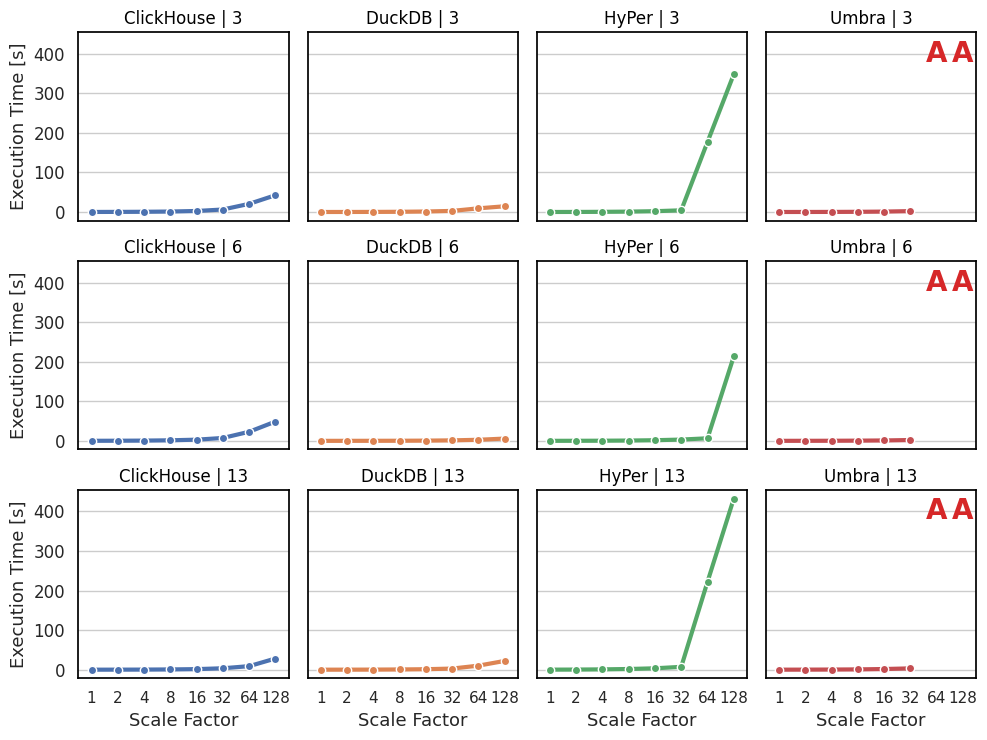

In [90]:
nums = [3, 6, 13]
groups = []
for num in nums:
    groups.append(f"""'{con.execute(f"SELECT num_grouping({num})").fetchall()[0][0]}'""")

f = plt.figure(figsize=(10, 7.5))
modified_style = copy.copy(my_style)
# modified_style['xtick.major.bottom'] = False
modified_style['axes.labelsize'] = 13
modified_style['ytick.labelsize'] = 12
# modified_style['ytick.major.left'] = False

p = (
    so.Plot(
        con.execute(f"""
            SELECT pretty_system(system) as System,
            sf AS "Scale Factor", grouping_num(grouping) as Grouping, wide, runtime AS "Execution Time [s]"
            FROM results_df
            WHERE grouping IN ({', '.join(groups)})
            AND wide = False
            AND runtime > 0
        """).fetchdf(),
        x='Scale Factor', y='Execution Time [s]', color='System'
    )
    .facet(col='System', row='Grouping')
    .add(so.Line(linewidth=3, marker='o', edgecolor='w'))
    # .share(x='col', y='row')
    .theme(modified_style)
    .on(f)
    .plot()
)

f.axes[3].text(6, 400, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette()[3], fontsize=20, weight='bold')
f.axes[3].text(7, 400, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette()[3], fontsize=20, weight='bold')
f.axes[7].text(6, 400, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette()[3], fontsize=20, weight='bold')
f.axes[7].text(7, 400, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette()[3], fontsize=20, weight='bold')
f.axes[11].text(6, 400, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette()[3], fontsize=20, weight='bold')
f.axes[11].text(7, 400, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette()[3], fontsize=20, weight='bold')

legend = f.legends.pop(0)
# f.axes[0].legend(legend.legend_handles, [t.get_text() for t in legend.texts], loc='upper left', framealpha=1, fontsize=15)
f.tight_layout()

f.savefig(f"../figures/thins_cliff.eps", bbox_inches='tight')
# plt.close(f)

In [35]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

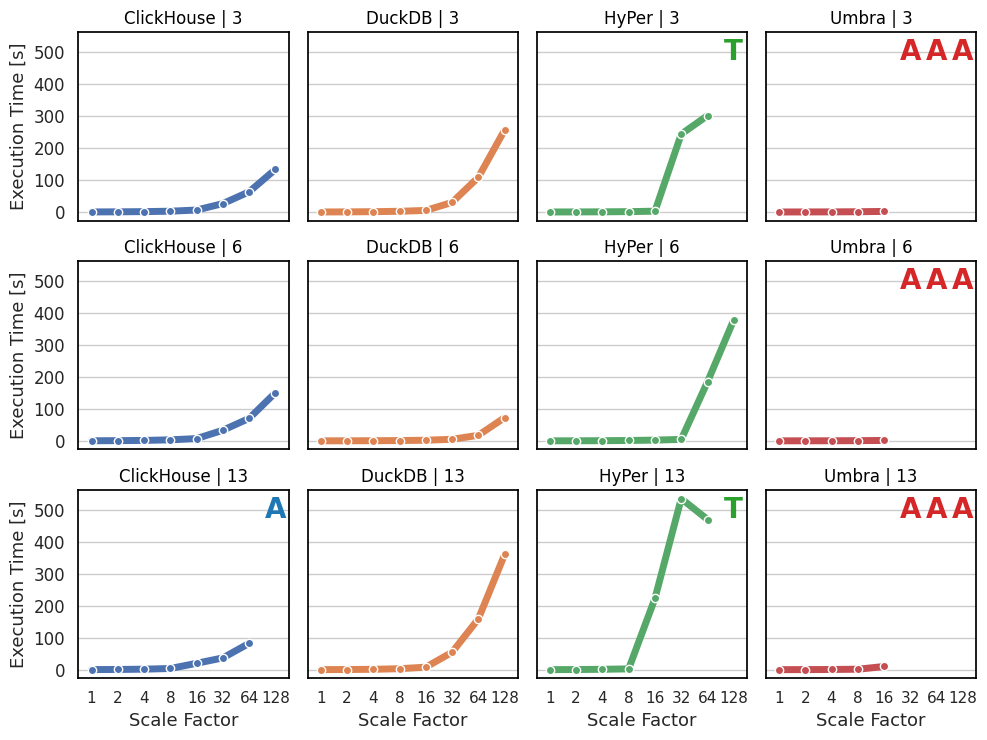

In [95]:
f = plt.figure(figsize=(10, 7.5))
modified_style = copy.copy(my_style)
# modified_style['xtick.major.bottom'] = False
modified_style['axes.labelsize'] = 13
modified_style['ytick.labelsize'] = 12
# modified_style['ytick.major.left'] = False

p = (
    so.Plot(
        con.execute(f"""
            SELECT pretty_system(system) as System,
            sf AS "Scale Factor", grouping_num(grouping) as Grouping, wide, runtime AS "Execution Time [s]"
            FROM results_df
            WHERE grouping IN ({', '.join(groups)})
            AND wide = True
            AND runtime > 0
        """).fetchdf(),
        x='Scale Factor', y='Execution Time [s]', color='System'
    )
    .facet(col='System', row='Grouping')
    .add(so.Line(linewidth=5, marker='o', edgecolor='w'))
    .theme(modified_style)
    .on(f)
    .plot()
)

legend = f.legends.pop(0)

f.axes[8].text(7, 500, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette()[0], fontsize=20, weight='bold')

f.axes[2].text(7, 500, "T", horizontalalignment='center', verticalalignment='center', color=sns.color_palette()[2], fontsize=20, weight='bold')
f.axes[10].text(7, 500, "T", horizontalalignment='center', verticalalignment='center', color=sns.color_palette()[2], fontsize=20, weight='bold')

f.axes[3].text(5, 500, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette()[3], fontsize=20, weight='bold')
f.axes[3].text(6, 500, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette()[3], fontsize=20, weight='bold')
f.axes[3].text(7, 500, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette()[3], fontsize=20, weight='bold')
f.axes[7].text(5, 500, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette()[3], fontsize=20, weight='bold')
f.axes[7].text(6, 500, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette()[3], fontsize=20, weight='bold')
f.axes[7].text(7, 500, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette()[3], fontsize=20, weight='bold')
f.axes[11].text(5, 500, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette()[3], fontsize=20, weight='bold')
f.axes[11].text(6, 500, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette()[3], fontsize=20, weight='bold')
f.axes[11].text(7, 500, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette()[3], fontsize=20, weight='bold')

# f.axes[0].legend(legend.legend_handles, [t.get_text() for t in legend.texts], loc='upper left', framealpha=1, fontsize=15)
f.tight_layout()

f.savefig(f"../figures/wides_cliff.eps", bbox_inches='tight')
# plt.close(f)

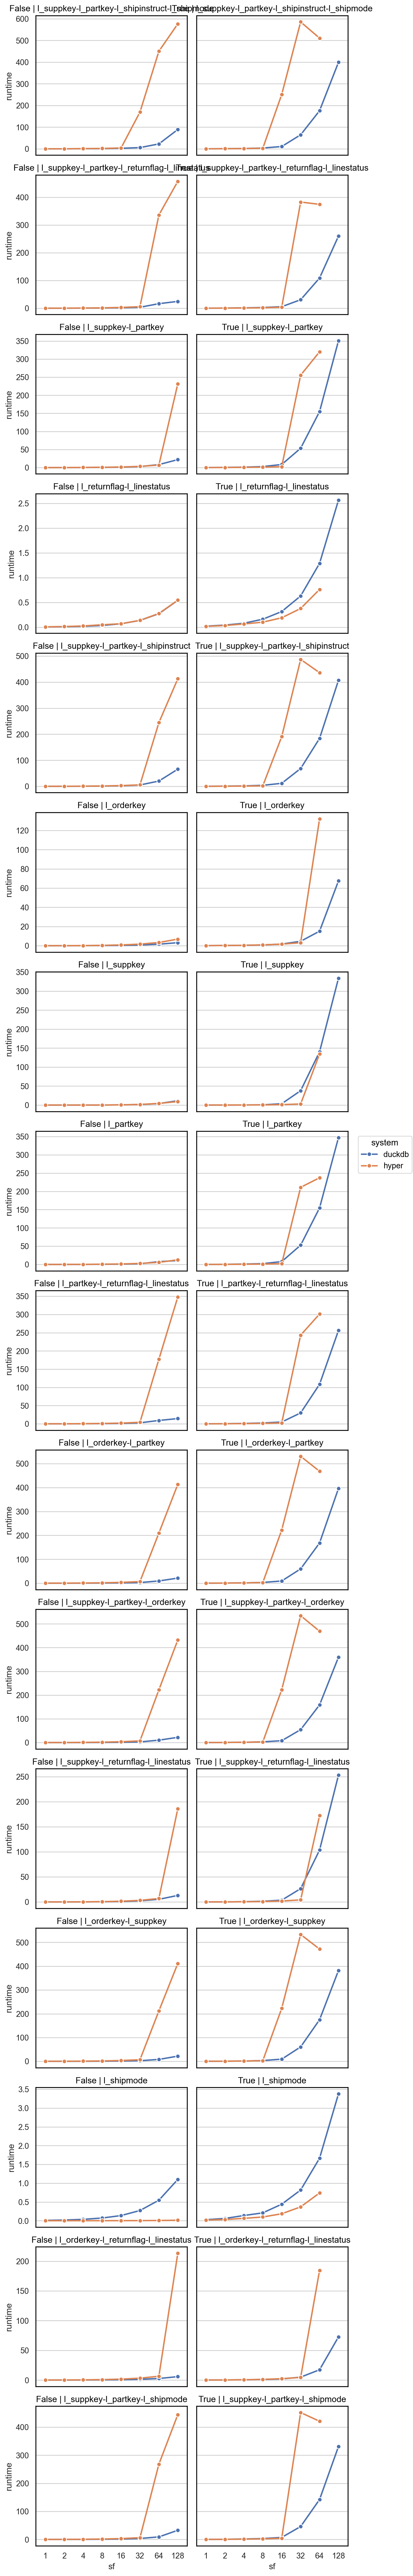

In [131]:
p = (
    so.Plot(results_df, x='sf', y='runtime', color='system')
    .facet(col='wide', row='grouping')
    .add(so.Line(linewidth=2, marker='o', edgecolor='w'))
    .share(x='col', y='row')
    .layout(size=(7, 50), engine='tight')
    .theme(my_style)
)
p

In [96]:
brev = con.execute("""
SELECT * EXCLUDE(wide)
FROM (
    SELECT * REPLACE(
    pretty_system(system)[:2] AS system,
    CASE WHEN runtime < 10 THEN format('{:.2f}', runtime)
    WHEN runtime < 100 THEN format('{:.1f}', runtime)
    WHEN runtime < 1000 THEN format('{:.0f}', runtime)
    ELSE runtime END AS runtime,
    grouping_num(grouping) AS grouping
    ) FROM results_int_df
    WHERE sf IN (2, 8, 32, 128)
    AND NOT wide
)""").fetchdf()
pivoted = brev.pivot_table(index=['grouping'], columns=['sf', 'system'], aggfunc="sum")
print(pivoted.to_latex().replace('-2.00', 'A'))

\begin{tabular}{lllllllllllllllll}
\toprule
 & \multicolumn{16}{r}{runtime} \\
sf & \multicolumn{4}{r}{2} & \multicolumn{4}{r}{8} & \multicolumn{4}{r}{32} & \multicolumn{4}{r}{128} \\
system & Cl & Du & Hy & Um & Cl & Du & Hy & Um & Cl & Du & Hy & Um & Cl & Du & Hy & Um \\
grouping &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
1 & 0.08 & 0.01 & 0.01 & 0.02 & 0.27 & 0.03 & 0.05 & 0.04 & 1.10 & 0.14 & 0.14 & 0.16 & 4.06 & 0.54 & 0.54 & A \\
2 & 0.04 & 0.08 & 0.13 & 0.04 & 0.16 & 0.44 & 0.66 & 0.19 & 0.75 & 2.03 & 2.86 & 0.68 & 4.04 & 10.8 & 12.8 & A \\
3 & 0.30 & 0.13 & 0.20 & 0.13 & 1.21 & 0.58 & 1.00 & 0.51 & 6.35 & 2.78 & 4.28 & 2.24 & 42.5 & 14.5 & 348 & A \\
4 & 0.08 & 0.12 & 0.16 & 0.07 & 0.29 & 0.58 & 0.83 & 0.28 & 1.63 & 2.86 & 3.38 & 1.22 & 9.80 & 22.1 & 232 & A \\
5 & 0.08 & 0.05 & 0.07 & 0.05 & 0.29 & 0.18 & 0.36 & 0.16 & 1.57 & 0.74 & 1.66 & 0.54 & 9.41 & 3.17 & 6.86 & A \\
6 & 0.35 & 0.08 & 0.21 & 0.15 & 1.42 & 0.30 & 0.81 & 0.55 & 7.32 & 1.27 & 3.27 & 2.12 & 4

In [99]:
brev = con.execute("""
SELECT * EXCLUDE(wide)
FROM (
    SELECT * REPLACE(
    pretty_system(system)[:2] AS system,
    CASE WHEN runtime < 10 THEN format('{:.2f}', runtime)
    WHEN runtime < 100 THEN format('{:.1f}', runtime)
    WHEN runtime < 1000 THEN format('{:.0f}', runtime)
    ELSE runtime END AS runtime,
    grouping_num(grouping) AS grouping
    ) FROM results_int_df
    WHERE sf IN (2, 8, 32, 128)
    AND wide
)""").fetchdf()
pivoted = brev.pivot_table(index=['grouping'], columns=['sf', 'system'], aggfunc="sum")
print(pivoted.to_latex().replace('-1.00', 'T').replace('-2.00', 'A'))

\begin{tabular}{lllllllllllllllll}
\toprule
 & \multicolumn{16}{r}{runtime} \\
sf & \multicolumn{4}{r}{2} & \multicolumn{4}{r}{8} & \multicolumn{4}{r}{32} & \multicolumn{4}{r}{128} \\
system & Cl & Du & Hy & Um & Cl & Du & Hy & Um & Cl & Du & Hy & Um & Cl & Du & Hy & Um \\
grouping &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
1 & 0.19 & 0.04 & 0.03 & 0.02 & 0.67 & 0.16 & 0.10 & 0.06 & 2.57 & 0.63 & 0.38 & A & 9.91 & 2.57 & 1.52 & A \\
2 & 0.34 & 0.42 & 0.23 & 0.22 & 1.45 & 2.25 & 1.07 & 0.77 & 18.4 & 52.8 & 211 & A & 112 & 347 & 499 & A \\
3 & 0.59 & 0.43 & 0.27 & 0.23 & 2.56 & 2.30 & 1.25 & 0.91 & 26.4 & 30.0 & 243 & A & 134 & 256 & T & A \\
4 & 0.51 & 0.53 & 0.27 & 0.23 & 2.43 & 2.77 & 1.28 & 0.91 & 26.2 & 53.5 & 256 & A & 123 & 351 & T & A \\
5 & 0.58 & 0.25 & 0.23 & 0.13 & 2.96 & 0.80 & 0.89 & 0.44 & 30.2 & 4.63 & 3.13 & A & A & 67.6 & 288 & A \\
6 & 0.72 & 0.23 & 0.29 & 0.17 & 3.24 & 1.01 & 1.22 & 0.67 & 33.2 & 4.96 & 4.56 & A & 151 & 72.7 & 378 & A \\
7 & 0.75 & 0.

In [128]:
con.execute("""
SELECT wide,
       sf,
       system,
       geomean(runtime) AS gruntime
FROM results_int_df
WHERE runtime > 0
GROUP BY wide,
         sf,
         system
ORDER BY wide,
         sf,
         gruntime
""").fetchdf()

,wide,sf,system,gruntime
0,False,1,duckdb,0.049995
1,False,1,umbra,0.061342
2,False,1,hyper,0.083780
3,False,1,clickhouse,0.088832
4,False,2,duckdb,0.104566
5,False,2,umbra,0.118657
6,False,2,clickhouse,0.176294
7,False,2,hyper,0.187956
8,False,4,duckdb,0.213313
9,False,4,umbra,0.234753


In [132]:
scores = con.execute("""
WITH best_in_group AS (
--    SELECT grouping_num(grouping) AS grouping,
--           sf,
--           wide,
--           min(runtime) AS min_runtime
--    FROM results_int_df
--    WHERE runtime > 0
--      AND sf IN (2, 8, 32, 128)
--    GROUP BY grouping, wide, sf
      SELECT grouping_num(grouping) AS grouping,
             sf,
             wide,
             runtime AS min_runtime
      FROM results_int_df
      WHERE system = 'duckdb'
        AND sf IN (2, 8, 32, 128)
), relative AS (
    SELECT r.system,
           grouping_num(r.grouping) AS grouping,
           r.sf,
           r.wide,
           runtime / b.min_runtime AS relative_runtime
    FROM best_in_group b,
         results_int_df r
    WHERE b.grouping = grouping_num(r.grouping)
      AND b.sf = r.sf
      AND b.wide = r.wide
      AND r.runtime > 0
    ORDER BY r.sf, r.wide, grouping, r.system
), gmeans AS (
    SELECT sf,
           system,
           wide,
           geomean(relative_runtime) AS g
    FROM relative
    GROUP BY sf,
             system,
             wide
    ORDER BY wide,
             sf,
             g
)
SELECT * REPLACE(CASE WHEN g < 10 THEN format('{:.2f}', g)
                      WHEN g < 100 THEN format('{:.1f}', g)
                      ELSE g END AS g)
FROM gmeans
""").fetchdf()
pivoted_scores = scores.pivot_table(columns=['wide', 'sf', 'system'], aggfunc="sum")
pivoted_scores

wide        False                                                              \
sf            2                             8                             32    
system clickhouse duckdb hyper umbra clickhouse duckdb hyper umbra clickhouse   
g            1.69   1.00  1.80  1.13       1.53   1.00  1.98  0.98       1.69   

wide           ...      True                                              \
sf             ...        8                             32                 
system duckdb  ... clickhouse duckdb hyper umbra clickhouse duckdb hyper   
g        1.00  ...       1.45   1.00  0.70  0.45       1.06   1.00  4.54   

wide                            
sf            128               
system clickhouse duckdb hyper  
g            0.86   1.00  2.08  

[1 rows x 29 columns]

In [133]:
print(pivoted_scores.to_latex())

\begin{tabular}{llllllllllllllllllllllllllllll}
\toprule
wide & \multicolumn{15}{r}{False} & \multicolumn{14}{r}{True} \\
sf & \multicolumn{4}{r}{2} & \multicolumn{4}{r}{8} & \multicolumn{4}{r}{32} & \multicolumn{3}{r}{128} & \multicolumn{4}{r}{2} & \multicolumn{4}{r}{8} & \multicolumn{3}{r}{32} & \multicolumn{3}{r}{128} \\
system & clickhouse & duckdb & hyper & umbra & clickhouse & duckdb & hyper & umbra & clickhouse & duckdb & hyper & umbra & clickhouse & duckdb & hyper & clickhouse & duckdb & hyper & umbra & clickhouse & duckdb & hyper & umbra & clickhouse & duckdb & hyper & clickhouse & duckdb & hyper \\
\midrule
g & 1.69 & 1.00 & 1.80 & 1.13 & 1.53 & 1.00 & 1.98 & 0.98 & 1.69 & 1.00 & 2.17 & 0.94 & 1.48 & 1.00 & 8.74 & 1.53 & 1.00 & 0.77 & 0.54 & 1.45 & 1.00 & 0.70 & 0.45 & 1.06 & 1.00 & 4.54 & 0.86 & 1.00 & 2.08 \\
\bottomrule
\end{tabular}

